In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2

import sys
sys.path.append('../')
sys.path.append('../../')

from camera_calibration.camera_calibration import read_calibration, undistort_image
from color_and_gradient import pipeline as color_pipeline
from warp_perspective import calibrate_warp, read_warp, warp_image

from utils.plot_utils import plt_imlist

from moviepy.editor import VideoFileClip

import ipywidgets as widgets
from IPython.display import HTML, display, clear_output

In [2]:
straight_images = glob.glob("../test_images/straight_lines*.jpg")
int_params = read_calibration("../camera_calibration/camera_intrinsics.pkl")

## Tune source and destination ROI manually

In [3]:
def draw_trapez(idx, xs1, xs2, ys):
    img = mpimg.imread(straight_images[idx])
    img_rect = undistort_image(img, int_params)
    src = [[xs1[0], ys[1]], [xs1[1], ys[1]], 
           [xs2[1], ys[0]], [xs2[0], ys[0]]]
    cv2.polylines(img_rect, np.array([src]), True, (255,0,255), 2)
    plt.figure()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.imshow(img_rect)
    plt.show()  

In [4]:
widgets.interactive(draw_trapez, 
                    idx=0,
                    xs1=widgets.IntRangeSlider(min=200, max=1200, step=1, value=[308, 1025]), 
                    xs2=widgets.IntRangeSlider(min=500, max=800, step=1, value=[595, 707]), 
                    ys=widgets.IntRangeSlider(min=400, max=720-1, step=1, value=[460, 680]))

interactive(children=(IntSlider(value=0, description='idx', max=1), IntRangeSlider(value=(308, 1025), descript…

### Save optimal value

In [5]:
ys = (460, 680)
xs1 = (308, 1026)
xs2 = (595.5, 707.5)

src = [[xs1[0], ys[1]], [xs1[1], ys[1]], [xs2[1], ys[0]], [xs2[0], ys[0]]]
dst = [[256, 719], [1024, 719], [1024, 0], [256, 0]]

### Run calibration

In [6]:
M = calibrate_warp("perspective.pkl", src=src, dst=dst)
#M = read_warp("perspective.p")
print(M)

[[-6.64882733e-01 -1.47936408e+00  1.05162286e+03]
 [-8.86447078e-16 -2.03148906e+00  9.34484968e+02]
 [-1.62237576e-18 -2.38470014e-03  1.00000000e+00]]


## Test result on straight lines

<Figure size 1440x720 with 0 Axes>

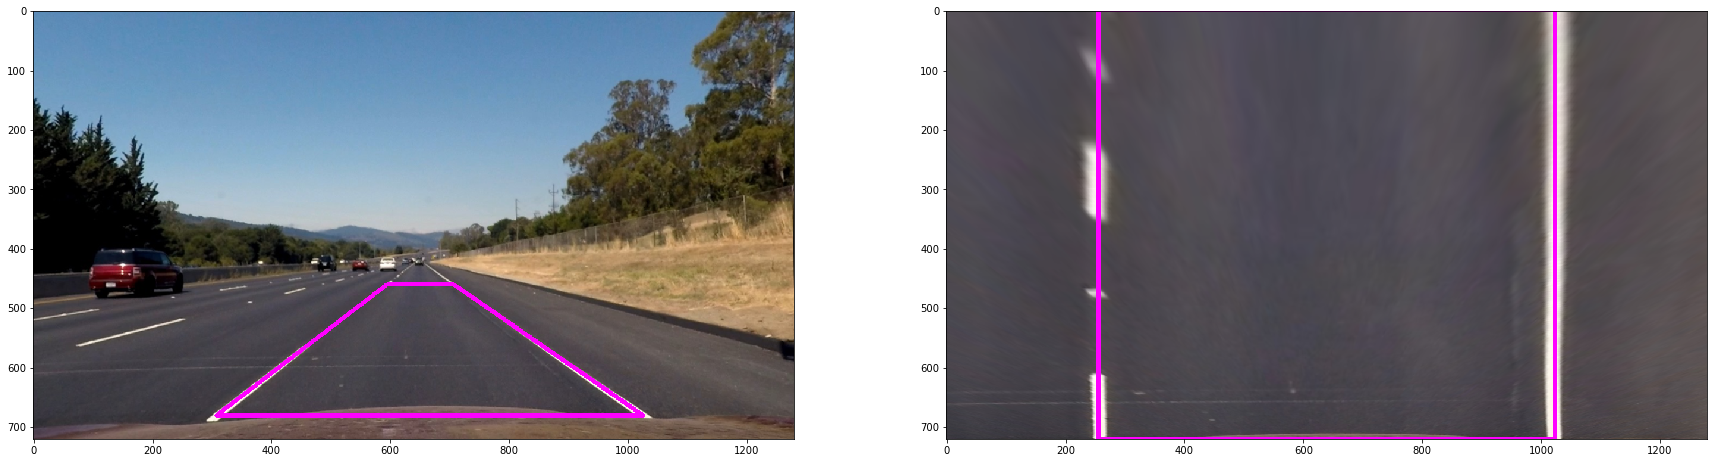

<Figure size 2160x1080 with 0 Axes>

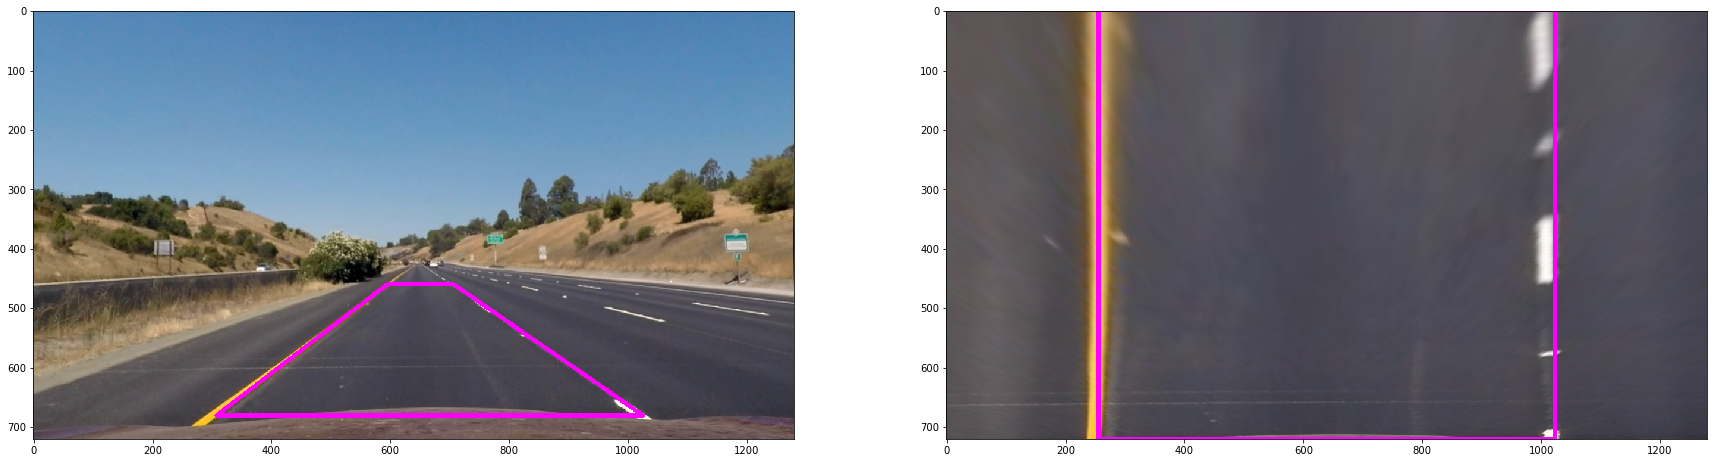

In [7]:
for image in straight_images:
    img = mpimg.imread(image)
    img_size = (img.shape[1], img.shape[0])
    img_rect = undistort_image(img, int_params)
    img_warped = cv2.warpPerspective(img_rect, M, img_size, flags=cv2.INTER_LINEAR)
    cv2.polylines(img_rect, np.array([src],dtype=np.int), True, (255,0,255), 5)
    cv2.polylines(img_warped, np.array([dst]), True, (255,0,255), 5)
    plt_imlist([img_rect, img_warped])
    

## Test on all test images with thresholding

<Figure size 2160x1080 with 0 Axes>

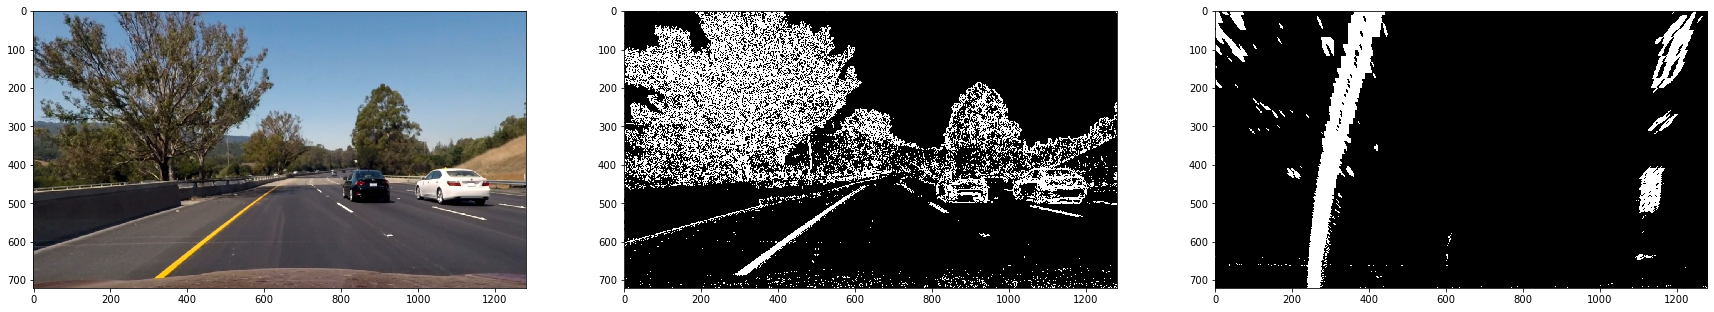

<Figure size 2160x1080 with 0 Axes>

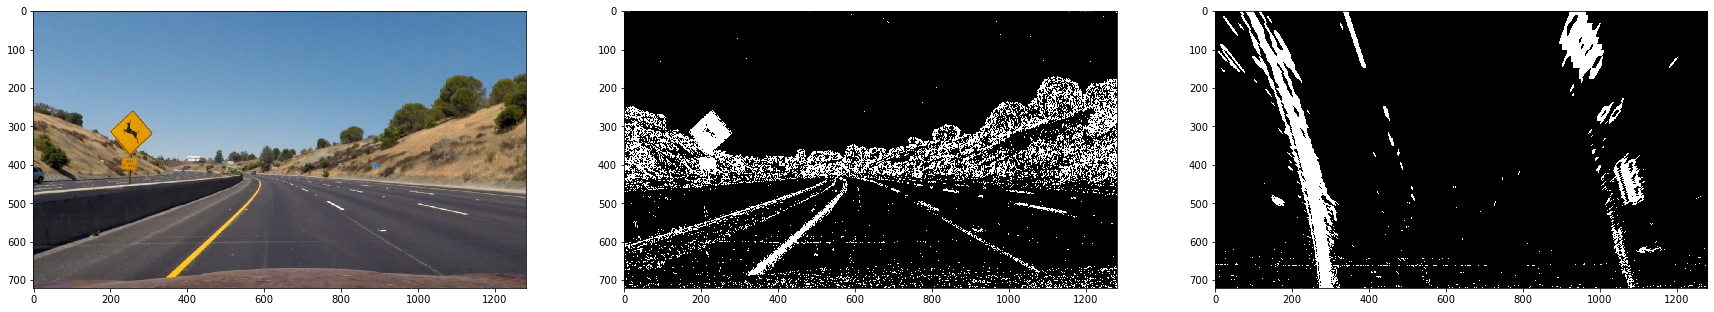

<Figure size 2160x1080 with 0 Axes>

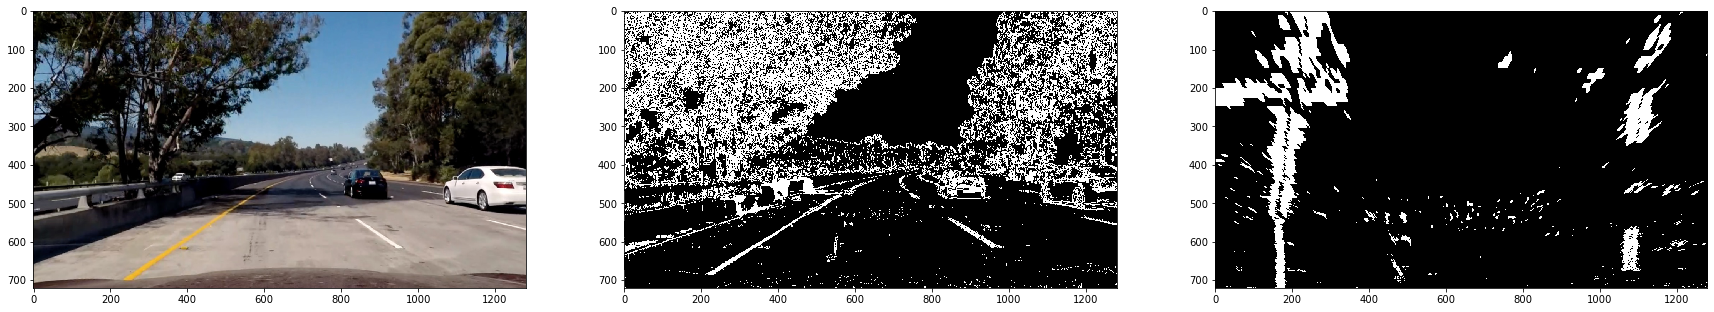

<Figure size 2160x1080 with 0 Axes>

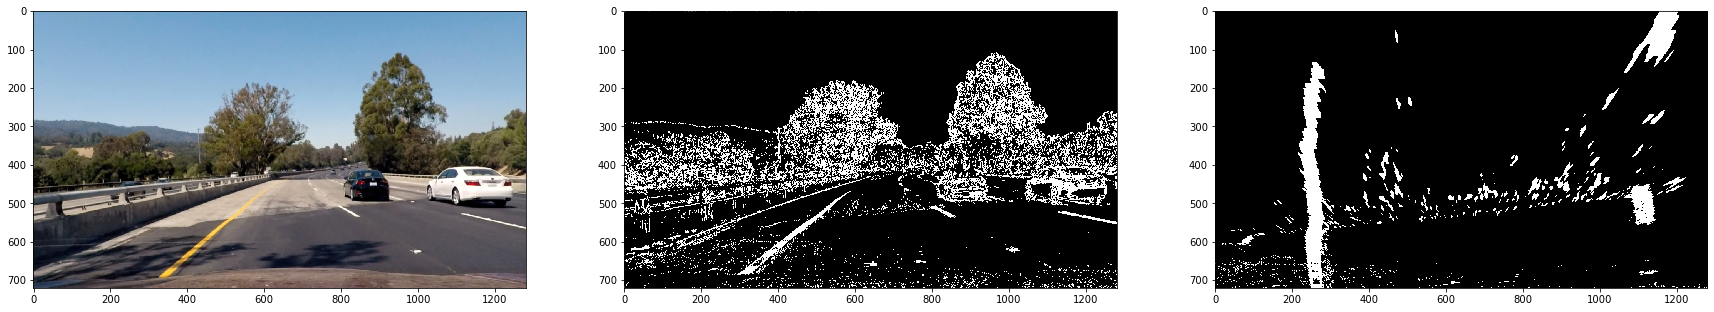

<Figure size 2160x1080 with 0 Axes>

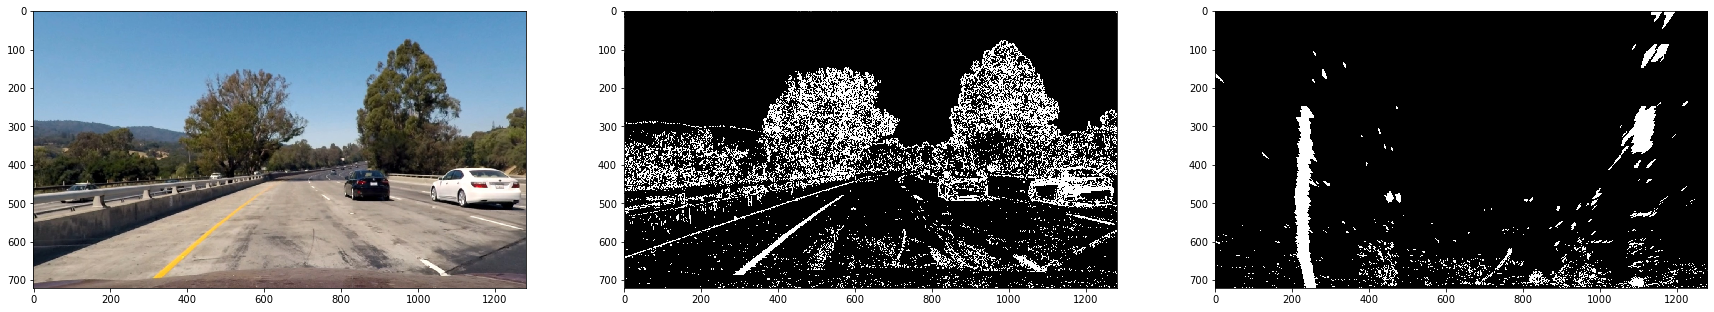

<Figure size 2160x1080 with 0 Axes>

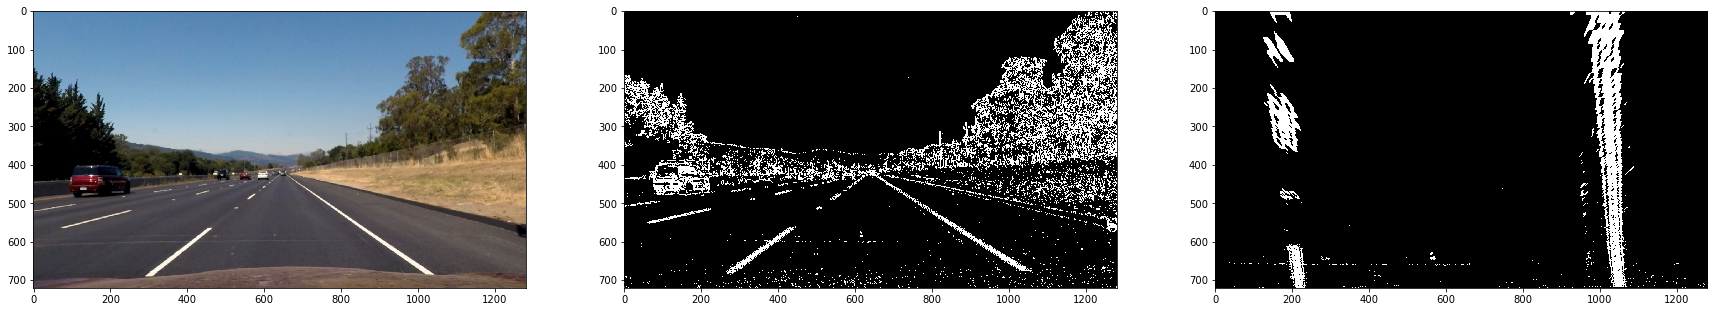

<Figure size 2160x1080 with 0 Axes>

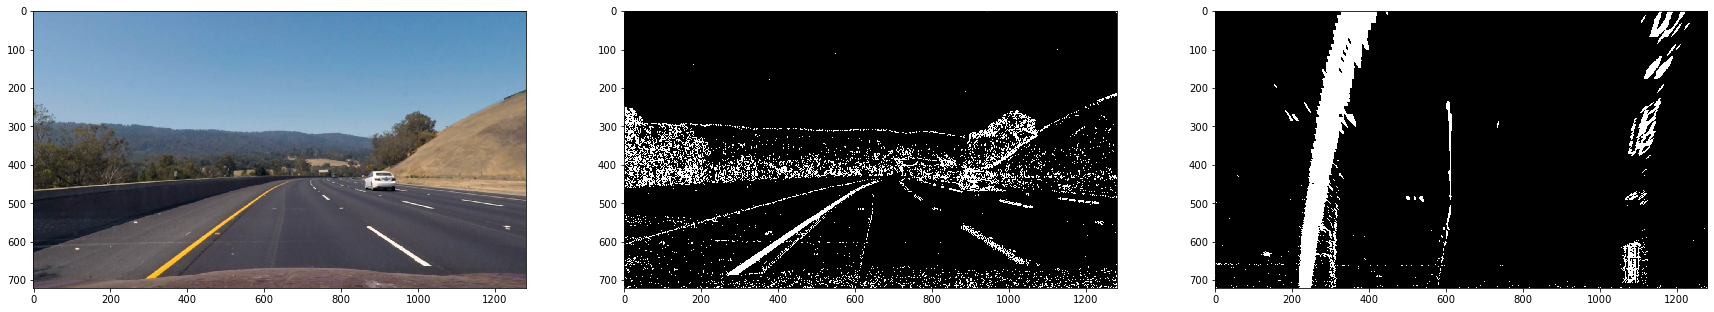

<Figure size 2160x1080 with 0 Axes>

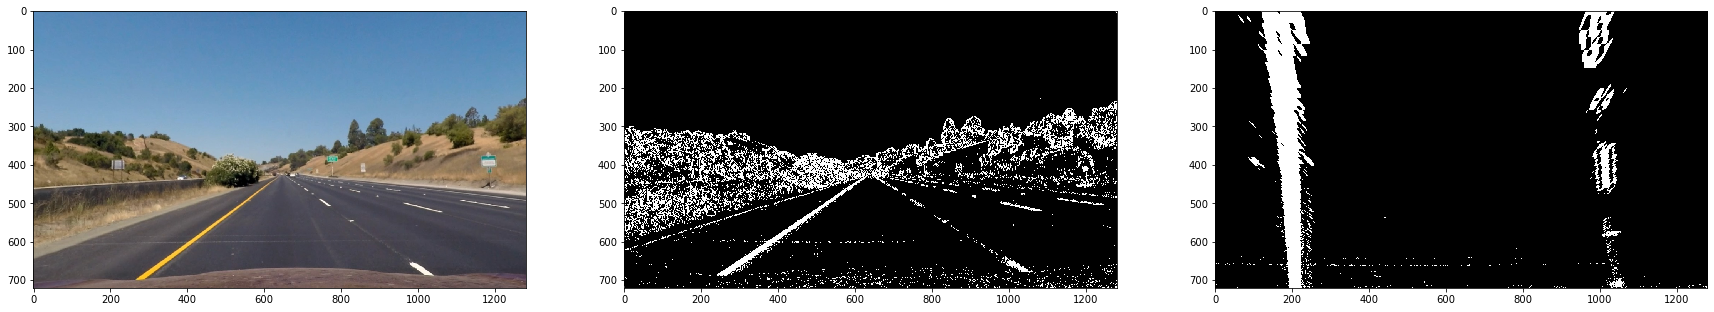

In [8]:
for image in glob.glob("../test_images/*.jpg"):
    img = mpimg.imread(image)
    img_rect = undistort_image(img, int_params)
    img_thresh = color_pipeline(img, s_thresh=(170, 255), sx_thresh=(10, 100))
    img_warped = warp_image(img_thresh, M)
    plt_imlist([img_rect, img_thresh, img_warped])

## Test on challenge video frames

<Figure size 2160x1080 with 0 Axes>

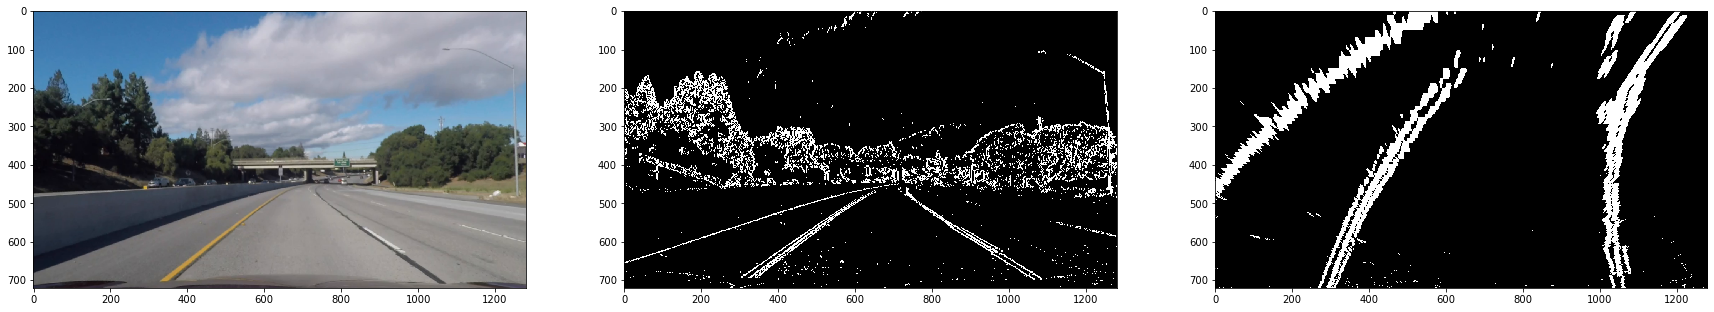

<Figure size 2160x1080 with 0 Axes>

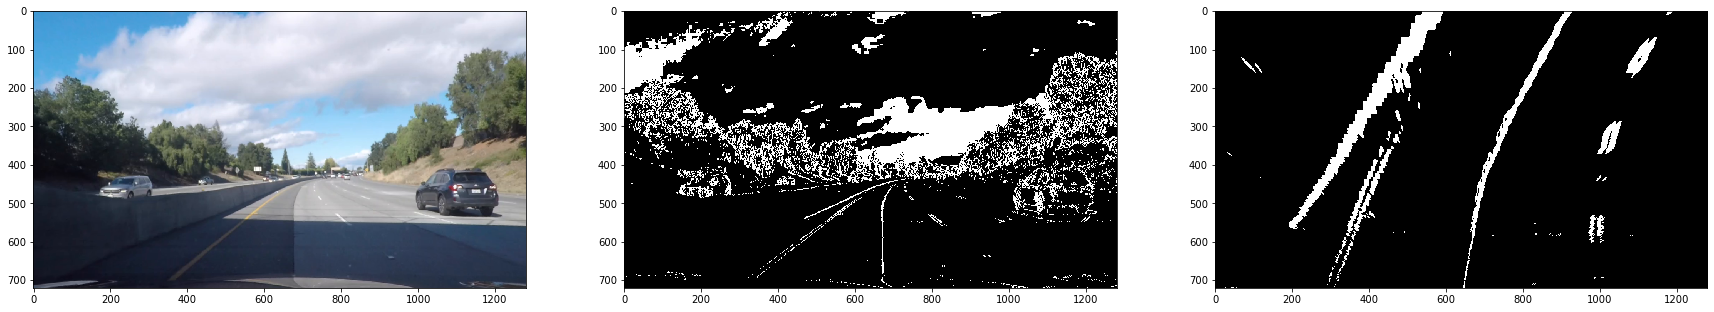

<Figure size 2160x1080 with 0 Axes>

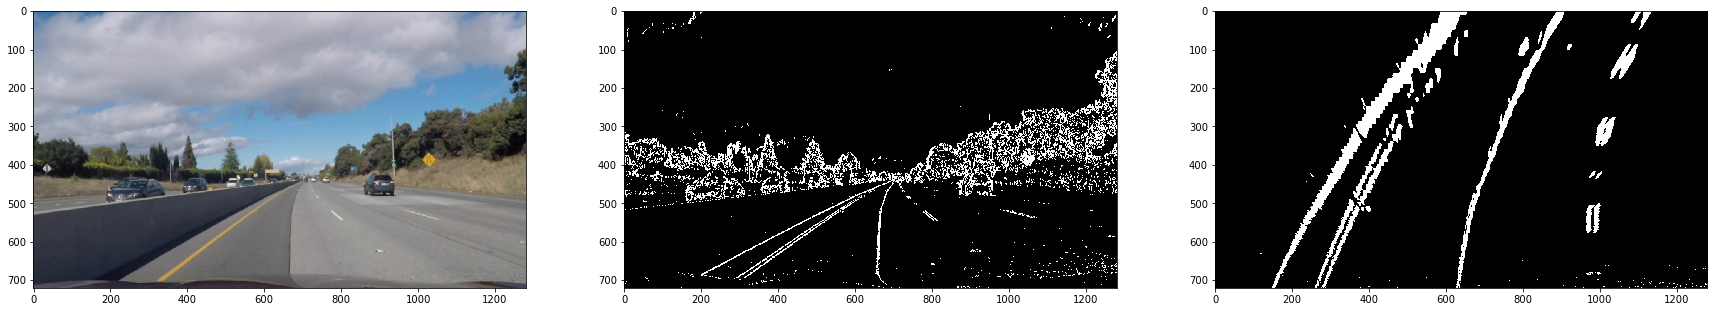

In [9]:
video = VideoFileClip('../test_videos/challenge_video.mp4')
np_frame = video.get_frame(2) # get the frame at t=2 seconds

for i in range(3):
    img = video.get_frame(i*5)
    img_rect = undistort_image(img, int_params)
    img_thresh = color_pipeline(img, s_thresh=(170, 255), sx_thresh=(10, 100))
    img_warped = warp_image(img_thresh, M)
    
    plt_imlist([img_rect, img_thresh, img_warped])